# PA3 - Build GPT-2 from Scratch


In [1]:
!pip install -U datasets tokenizers

     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 57.7/57.7 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/491.5 kB ? eta -:--:--
   --------------------------------------  491.5/491.5 kB 15.5 MB/s eta 0:00:01
   --------------------------------------- 491.5/491.5 kB 10.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ------------- -------------------------- 0.9/2.5 MB 27.4 MB/s eta 0:00:01
   ------------------------------- -------- 2.0/2.5 MB 21.1 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 20.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/116.3 kB ? eta -:--:--
   ---------------------------------------- 116.3/116.3 kB ? eta 0:00:00
   ---------------------------------------- 0.0/143.5 kB ? eta -:--:--
   ---------------------------------------- 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   -------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.46.3 requires tokenizers<0.21,>=0.20, but you have tokenizers 0.21.2 which is incompatible.


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


## Loading, Tokenizing and Preprocessing Dataset

In [28]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", revision="main")
text_data = dataset["train"]["text"]
text_data = [line for line in text_data if line.strip()]
print("Number of lines:", len(text_data))
print("Sample:", text_data[0])

Number of lines: 23767
Sample:  = Valkyria Chronicles III = 



In [29]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents, Sequence as NormalizerSequence
from tokenizers.pre_tokenizers import Whitespace

# Save dataset to text file
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in text_data:
        if line.strip():
            f.write(line.strip() + "\n")

# 1. Initialize BPE model
tokenizer = Tokenizer(models.BPE())


tokenizer.normalizer = NormalizerSequence([NFD(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()

trainer = trainers.BpeTrainer(
    vocab_size=32000,
    special_tokens=["<pad>", "<unk>"]
)


tokenizer.train(files=["corpus.txt"], trainer=trainer)


tokenizer.save("bpe_tokenizer.json")

# 6. Quick test
encoded = tokenizer.encode("The quick brown fox jumps over the lazy dog.")
print("Encoded IDs:", encoded.ids)
print("Decoded text:", tokenizer.decode(encoded.ids))

Encoded IDs: [789, 2894, 2369, 3382, 11980, 972, 789, 13238, 64, 4918, 15]
Decoded text: the quick brown fox jumps over the laz y dog .


## Model Definition

In [30]:

class GPT2Config:
    def __init__(self, vocab_size=32000, block_size=128,
                 n_layer=4, n_head=4, n_embd=256):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd

class GPT2SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.attn = nn.MultiheadAttention(
            embed_dim=config.n_embd,
            num_heads=config.n_head,
            dropout=0.1,
            batch_first=True
        )
        self.proj = nn.Linear(config.n_embd, config.n_embd)

    def forward(self, x, attn_mask=None):
        out, _ = self.attn(x, x, x, attn_mask=attn_mask, need_weights=False)
        return self.proj(out)

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.attn = GPT2SelfAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.ff = FeedForward(config)

    def forward(self, x, attn_mask=None):
        x = x + self.attn(self.ln1(x), attn_mask=attn_mask)
        x = x + self.ff(self.ln2(x))
        return x

class GPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.config = config

    def forward(self, idx):
        B, T = idx.shape
        assert T <= self.block_size, f"Cannot forward sequence of length {T}, block size is {self.block_size}"

        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)
        x = self.token_emb(idx) + self.pos_emb(pos)

        mask = torch.triu(torch.full((T, T), -1e9, device=x.device), diagonal=1)

        for block in self.blocks:
            x = block(x, attn_mask=mask)

        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

### Training a Standard Small GPT-2 model with  Multihead Attention

In [31]:
config = GPT2Config(
    vocab_size=32000,
    block_size=128,   # sequence length
    n_layer=12,
    n_head=12,
    n_embd=768
)

In [32]:
# Load tokenizer
tokenizer = Tokenizer.from_file("bpe_tokenizer.json")

def encode_dataset(text_list, block_size=128):
    token_ids = []
    for line in text_list:
        if line.strip():
            encoded = tokenizer.encode(line)
            token_ids.extend(encoded.ids)
    
    # Truncate to a multiple of block_size
    n_total = len(token_ids) // block_size * block_size
    token_ids = token_ids[:n_total]

    # Create input/target chunks
    input_ids = torch.tensor(token_ids, dtype=torch.long)
    inputs = input_ids.view(-1, block_size)
    targets = input_ids.roll(-1, dims=0).view(-1, block_size)
    
    return inputs, targets

inputs, targets = encode_dataset(text_data, block_size=config.block_size)
print("Shape:", inputs.shape)  # (num_samples, block_size)

Shape: torch.Size([16892, 128])


In [33]:
from torch.utils.data import Dataset, DataLoader, random_split

class GPT2Dataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    
    def __len__(self):
        return self.inputs.size(0)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Full dataset
full_dataset = GPT2Dataset(inputs, targets)

# 90-10 split
n_total = len(full_dataset)
n_val = int(0.1 * n_total)
n_train = n_total - n_val

train_data, val_data = random_split(full_dataset, [n_train, n_val])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Training samples: 15203
Validation samples: 1689
Number of training batches: 1901
Number of validation batches: 212


In [34]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import math

model = GPT2(config).cuda()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params / 1e6:.2f}M")

def lr_lambda(step):
    warmup = 500
    if step < warmup:
        return step / warmup
    progress = (step - warmup) / (10000 - warmup)
    return 0.5 * (1 + math.cos(progress * math.pi))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

Trainable parameters: 141.39M


In [35]:
def evaluate(model, val_loader, device):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            val_loss += loss.item()
    model.train()
    return val_loss / len(val_loader)

In [36]:
import torch
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
os.makedirs("checkpoints", exist_ok=True)

def train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=3, grad_accum_steps=1):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    device = next(model.parameters()).device

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        optimizer.zero_grad()

        for i, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()

            if (i + 1) % grad_accum_steps == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()
            pbar.set_postfix(train_loss=loss.item())

        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = evaluate(model, val_loader, device)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"\nEpoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        torch.save(model.state_dict(), f"checkpoints/gpt2_epoch{epoch+1}.pt")

    return train_losses, val_losses

Epoch 1: 100%|████████████████████████████████████████████████████| 1901/1901 [40:27<00:00,  1.28s/it, train_loss=6.34]



✅ Epoch 1: Train Loss = 6.6932, Val Loss = 6.0722


Epoch 2: 100%|████████████████████████████████████████████████████| 1901/1901 [40:27<00:00,  1.28s/it, train_loss=4.86]



✅ Epoch 2: Train Loss = 5.6748, Val Loss = 5.6138


Epoch 3: 100%|████████████████████████████████████████████████████| 1901/1901 [40:27<00:00,  1.28s/it, train_loss=5.06]



✅ Epoch 3: Train Loss = 5.0911, Val Loss = 5.3742


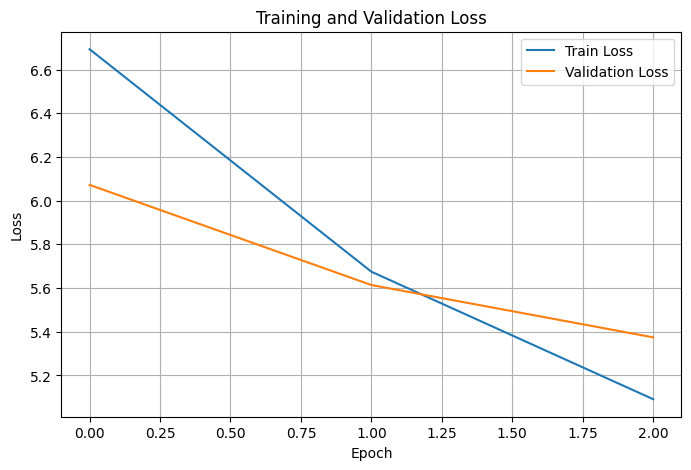


📊 Final Validation Loss: 5.3742
🧠 Perplexity: 215.77


In [41]:
import matplotlib.pyplot as plt
import math

train_losses, val_losses = train(
    model, train_loader, val_loader,
    optimizer, scheduler,
    num_epochs=3, grad_accum_steps=1
)

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Final perplexity from last val loss
final_val_loss = val_losses[-1]
perplexity = math.exp(final_val_loss)
print(f"\n📊 Final Validation Loss: {final_val_loss:.4f}")
print(f"🧠 Perplexity: {perplexity:.2f}")

In [44]:
import torch
import torch.nn.functional as F

def sample_next_token(logits, strategy="greedy", top_k=50, top_p=0.9, temperature=1.0):
    logits = logits / temperature
    probs = F.softmax(logits, dim=-1)
    
    if strategy == "greedy":
        return torch.argmax(probs, dim=-1)
    elif strategy == "top-k":
        topk_probs, topk_indices = torch.topk(probs, k=top_k)
        topk_probs = topk_probs / topk_probs.sum(dim=-1, keepdim=True)
        next_token = torch.multinomial(topk_probs, num_samples=1)
   
        return topk_indices.gather(-1, next_token).squeeze(-1)
    elif strategy == "nucleus":
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = sorted_probs.cumsum(dim=-1)
        cutoff = cumulative_probs > top_p
        cutoff[..., 1:] = cutoff[..., :-1].clone()
        cutoff[..., 0] = 0
        sorted_probs[cutoff] = 0
        sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)
        next_token = torch.multinomial(sorted_probs, num_samples=1)

        return sorted_indices.gather(-1, next_token).squeeze(-1)
    else:
        raise ValueError(f"Unknown decoding strategy: {strategy}")

def generate_text(model, tokenizer, prompt, max_tokens=50, strategy="greedy", top_k=50, top_p=0.9, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device
    ids = tokenizer.encode(prompt).ids
    input_ids = torch.tensor([ids], dtype=torch.long).to(device)
    
    for _ in range(max_tokens):  
        idx_cond = input_ids[:, -config.block_size:]  
        logits = model(idx_cond)
        next_token_logits = logits[:, -1, :]  
        
        next_token = sample_next_token(
            next_token_logits,
            strategy=strategy,
            top_k=top_k,
            top_p=top_p,
            temperature=temperature
        )
        

        input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=1)
    
    output_text = tokenizer.decode(input_ids[0].tolist())
    return output_text

# Test the generation
prompt = "Once upon a time"
print("Greedy decoding:\n", generate_text(model, tokenizer, prompt, strategy="greedy"))
print("\nTop-k sampling (k=50):\n", generate_text(model, tokenizer, prompt, strategy="top-k", top_k=50))
print("\nNucleus sampling (p=0.9):\n", generate_text(model, tokenizer, prompt, strategy="nucleus", top_p=0.9))

Greedy decoding:
 once upon a time . the first time in the second season , the second half of the season , and the second half of the season , was the first time in the season . the first time in the season , the first time in the final game , and the final

Top-k sampling (k=50):
 once upon a time . " i don ' t want out in the top ten singles , and he ' t say in much of his best friend ross ' s most iconic career " . on 27 january 2014 , dylan made his first album title on the new york times ,

Nucleus sampling (p=0.9):
 once upon a time lot , and the human tit aff ly provided the cl lions lion . james sandra as a variant of his father knew , in a letter to the world , " two been widely stored of a mosaic inspiration for them " , and stating that his five one


### Training a Standard Medium GPT-2 model with multihead attention


In [21]:
medium_config = GPT2Config(
    vocab_size=32000,     # Your trained BPE tokenizer
    block_size=128,       
    n_layer=24,
    n_head=16,
    n_embd=1024
)

In [22]:
medium_model = GPT2(medium_config).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params / 1e6:.2f}M")

from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import math

def lr_lambda(step):
    warmup = 500
    if step < warmup:
        return step / warmup
    progress = (step - warmup) / (10000 - warmup)
    return 0.5 * (1 + math.cos(progress * math.pi))

optimizer = AdamW(medium_model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

Trainable parameters: 393.17M


In [23]:
num_epochs = 3
batch_size = 2
grad_accum_steps = 4

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Training samples: 15203
Validation samples: 1689
Number of training batches: 7602
Number of validation batches: 845


In [24]:
train_losses, val_losses = train(
    medium_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    grad_accum_steps=grad_accum_steps
)

Epoch 1: 100%|██████████████████████████████████████████████████| 7602/7602 [3:45:55<00:00,  1.78s/it, train_loss=5.94]



✅ Epoch 1: Train Loss = 6.5629, Val Loss = 5.9593


Epoch 2: 100%|██████████████████████████████████████████████████| 7602/7602 [3:40:07<00:00,  1.74s/it, train_loss=5.59]



✅ Epoch 2: Train Loss = 5.5453, Val Loss = 5.4507


Epoch 3: 100%|███████████████████████████████████████████████████| 7602/7602 [3:40:17<00:00,  1.74s/it, train_loss=4.7]



✅ Epoch 3: Train Loss = 4.8569, Val Loss = 5.1724


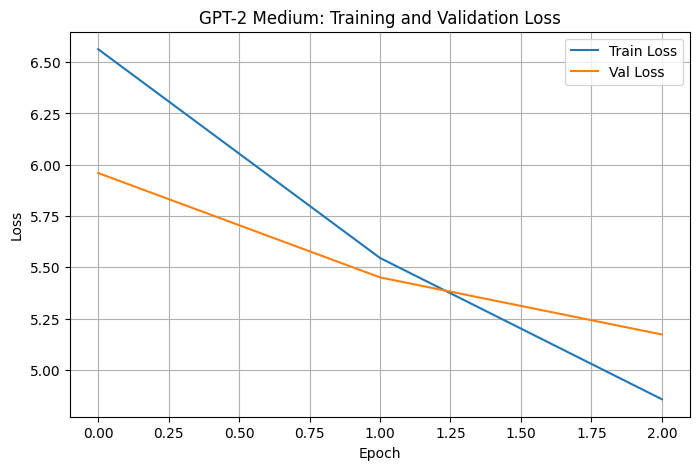

Final Val Loss: 5.1724
Perplexity: 176.34


In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GPT-2 Medium: Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Perplexity: {math.exp(val_losses[-1]):.2f}")

In [43]:

# Test the generation
prompt = "Once upon a time"
print("Greedy decoding:\n", generate_text(medium_model, tokenizer, prompt, strategy="greedy"))
print("\n Top-k sampling (k=50):\n", generate_text(medium_model, tokenizer, prompt, strategy="top-k", top_k=50))
print("\n Nucleus sampling (p=0.9):\n", generate_text(medium_model, tokenizer, prompt, strategy="nucleus", top_p=0.9))

Greedy decoding:
 once upon a time when he was appointed as a member of the club ' s first club , and he was appointed as a manager of the club ' s first club . he was the first player of the season in the first season , and was the first player of the

 Top-k sampling (k=50):
 once upon a time when he began to become a public on the next day after he decided at the university of fame , in london , where he left the school of england , and claimed that wheeler had received a good of college , calling it " a good student ... this

 Nucleus sampling (p=0.9):
 once upon a time when he has previously worked for me / 50 years . = = = writing = = = = = journey to chess arts and cambridge olympic market = = = in 1994 , it was released as an " course for land " , and produced as an 2


In [18]:
print(torch.__version__)

2.2.0+cu121


### Standard Small GPT-2 Model with Flash attention

In [19]:
class GPT2Config:
    def __init__(self, vocab_size=32000, block_size=128,
                 n_layer=4, n_head=4, n_embd=256):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd

class GPT2SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.head_dim = config.n_embd // config.n_head
        self.embed_dim = config.n_embd

        self.qkv_proj = nn.Linear(self.embed_dim, 3 * self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, x):
        B, T, C = x.size()  # [batch, time, channels]
        qkv = self.qkv_proj(x)  # [B, T, 3 * C]
        qkv = qkv.view(B, T, self.n_head, 3 * self.head_dim)
        q, k, v = torch.chunk(qkv, 3, dim=-1)

        # [B, T, H, D] → [B, H, T, D]
        q, k, v = [t.permute(0, 2, 1, 3) for t in (q, k, v)]

        # merge heads: [B, H, T, D] → [B*H, T, D]
        q = q.reshape(B * self.n_head, T, self.head_dim)
        k = k.reshape(B * self.n_head, T, self.head_dim)
        v = v.reshape(B * self.n_head, T, self.head_dim)

        # FlashAttention via PyTorch 2.0+
        out = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        # reshape back: [B*H, T, D] → [B, T, C]
        out = out.view(B, self.n_head, T, self.head_dim)
        out = out.permute(0, 2, 1, 3).reshape(B, T, C)

        return self.out_proj(out)

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.attn = GPT2SelfAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.ff = FeedForward(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))  # pre-LN + residual
        x = x + self.ff(self.ln2(x))    # pre-LN + residual
        return x

class GPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.config = config

    def forward(self, idx):
        B, T = idx.shape
        assert T <= self.block_size, f"Cannot forward sequence of length {T}, block size is {self.block_size}"

        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)  # [1, T]
        x = self.token_emb(idx) + self.pos_emb(pos)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

In [37]:
config = GPT2Config(
    vocab_size=32000,
    block_size=128,   # sequence length
    n_layer=12,
    n_head=12,
    n_embd=768
)

In [38]:
# DataLoaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

In [39]:
small_flash_model = GPT2(config).to(device)

total_params = sum(p.numel() for p in small_flash_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params / 1e6:.2f}M")

optimizer = AdamW(small_flash_model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)


Trainable parameters: 141.39M


In [40]:
num_epochs = 3
batch_size = 8
grad_accum_steps = 1

train_losses, val_losses = train(
    small_flash_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    grad_accum_steps=grad_accum_steps
)



Epoch 1: 100%|████████████████████████████████████████████████████| 1901/1901 [04:56<00:00,  6.41it/s, train_loss=6.22]



Epoch 1: Train Loss = 6.6934, Val Loss = 6.0549


Epoch 2: 100%|████████████████████████████████████████████████████| 1901/1901 [04:59<00:00,  6.35it/s, train_loss=5.78]



Epoch 2: Train Loss = 5.6845, Val Loss = 5.5882


Epoch 3: 100%|████████████████████████████████████████████████████| 1901/1901 [05:01<00:00,  6.30it/s, train_loss=4.48]



Epoch 3: Train Loss = 5.1051, Val Loss = 5.3573


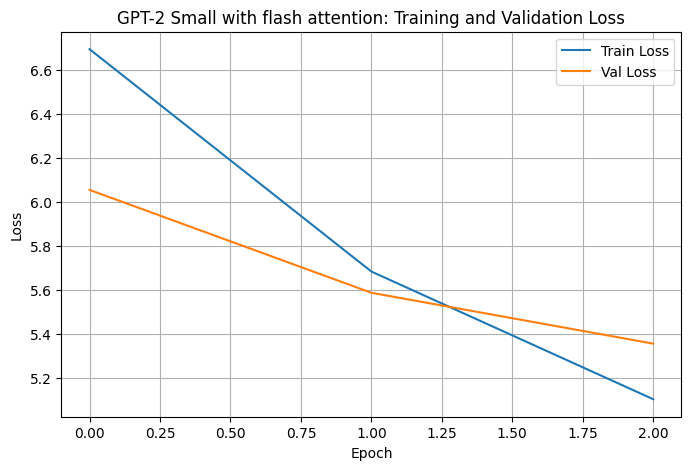

Final Val Loss: 5.3573
Perplexity: 212.16


In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GPT-2 Small with flash attention: Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Perplexity: {math.exp(val_losses[-1]):.2f}")

In [42]:
# Test the generation
def sample_next_token(logits, strategy="greedy", top_k=50, top_p=0.9, temperature=1.0):
    logits = logits / temperature
    probs = F.softmax(logits, dim=-1)
    
    if strategy == "greedy":
        return torch.argmax(probs, dim=-1)
    elif strategy == "top-k":
        topk_probs, topk_indices = torch.topk(probs, k=top_k)
        topk_probs = topk_probs / topk_probs.sum(dim=-1, keepdim=True)
        next_token = torch.multinomial(topk_probs, num_samples=1)
   
        return topk_indices.gather(-1, next_token).squeeze(-1)
    elif strategy == "nucleus":
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = sorted_probs.cumsum(dim=-1)
        cutoff = cumulative_probs > top_p
        cutoff[..., 1:] = cutoff[..., :-1].clone()
        cutoff[..., 0] = 0
        sorted_probs[cutoff] = 0
        sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)
        next_token = torch.multinomial(sorted_probs, num_samples=1)

        return sorted_indices.gather(-1, next_token).squeeze(-1)
    else:
        raise ValueError(f"Unknown decoding strategy: {strategy}")

def generate_text(model, tokenizer, prompt, max_tokens=50, strategy="greedy", top_k=50, top_p=0.9, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device
    ids = tokenizer.encode(prompt).ids
    input_ids = torch.tensor([ids], dtype=torch.long).to(device)
    
    for _ in range(max_tokens):  
        idx_cond = input_ids[:, -config.block_size:]  
        logits = model(idx_cond)
        next_token_logits = logits[:, -1, :]  
        
        next_token = sample_next_token(
            next_token_logits,
            strategy=strategy,
            top_k=top_k,
            top_p=top_p,
            temperature=temperature
        )
        

        input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=1)
    
    output_text = tokenizer.decode(input_ids[0].tolist())
    return output_text
prompt = "Once upon a time"
print("Greedy decoding:\n", generate_text(small_flash_model, tokenizer, prompt, strategy="greedy"))
print("\n Top-k sampling (k=50):\n", generate_text(small_flash_model, tokenizer, prompt, strategy="top-k", top_k=50))
print("\n Nucleus sampling (p=0.9):\n", generate_text(small_flash_model, tokenizer, prompt, strategy="nucleus", top_p=0.9))

Greedy decoding:
 once upon a time in the united states . = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

 Top-k sampling (k=50):
 once upon a time . according to a state board he was able to move towards a man who had failed to prove off at the end of a company and the new way to come on to the company . on 17 january when the german fleet continued , when of the british

 Nucleus sampling (p=0.9):
 once upon a time , peaking at the time . eaton would continue to go forward to the new rules and replace he made another liberation lack of blacks and the nearby traditional mon ol davenport . pitman revealed the bases of paying frames and bill approval be able to prevent him . he


### Standard small GPT-2 model with sparse windowed attention.

In [48]:
class GPT2Config:
    def __init__(self, vocab_size=32000, block_size=128,
                 n_layer=4, n_head=4, n_embd=256, window_size=32):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.window_size = window_size  # for sparse attention

class GPT2SparseSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.head_dim = config.n_embd // config.n_head
        self.embed_dim = config.n_embd
        self.window_size = config.window_size

        self.qkv_proj = nn.Linear(self.embed_dim, 3 * self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.qkv_proj(x)  # [B, T, 3*C]
        qkv = qkv.view(B, T, self.n_head, 3 * self.head_dim)
        q, k, v = torch.chunk(qkv, 3, dim=-1)

        # [B, T, H, D] -> [B, H, T, D]
        q, k, v = [t.permute(0, 2, 1, 3) for t in (q, k, v)]  # [B, H, T, D]

        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # [B, H, T, T]

        # Sparse causal attention mask 
        causal_mask = torch.full((T, T), float("-inf"), device=x.device)
        for i in range(T):
            start = max(0, i - self.window_size)
            causal_mask[i, start:i+1] = 0.0 

        scores = scores + causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, T, T]

        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v)  # [B, H, T, D]
        out = out.permute(0, 2, 1, 3).reshape(B, T, C)  # [B, T, C]

        return self.out_proj(out)

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.attn = GPT2SparseSelfAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.ff = FeedForward(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))  # pre-LN + residual
        x = x + self.ff(self.ln2(x))    # pre-LN + residual
        return x

class GPT2Sparse(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.block_size = config.block_size
        self.config = config

    def forward(self, idx):
        B, T = idx.shape
        assert T <= self.block_size
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)
        x = self.token_emb(idx) + self.pos_emb(pos)
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

In [49]:
config = GPT2Config(
    vocab_size=32000,
    block_size=128,   # sequence length
    n_layer=12,
    n_head=12,
    n_embd=768,
    window_size=32
)

In [50]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

In [51]:
small_sparse_model = GPT2Sparse(config).to(device)

total_params = sum(p.numel() for p in small_sparse_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params / 1e6:.2f}M")

optimizer = AdamW(small_sparse_model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

Trainable parameters: 134.31M


Epoch 1: 100%|████████████████████████████████████████████████████| 1901/1901 [05:40<00:00,  5.58it/s, train_loss=6.22]



Epoch 1: Train Loss = 6.6823, Val Loss = 6.0450


Epoch 2: 100%|█████████████████████████████████████████████████████| 1901/1901 [05:44<00:00,  5.52it/s, train_loss=5.2]



Epoch 2: Train Loss = 5.6698, Val Loss = 5.5896


Epoch 3: 100%|████████████████████████████████████████████████████| 1901/1901 [05:45<00:00,  5.50it/s, train_loss=4.75]



Epoch 3: Train Loss = 5.0752, Val Loss = 5.3679


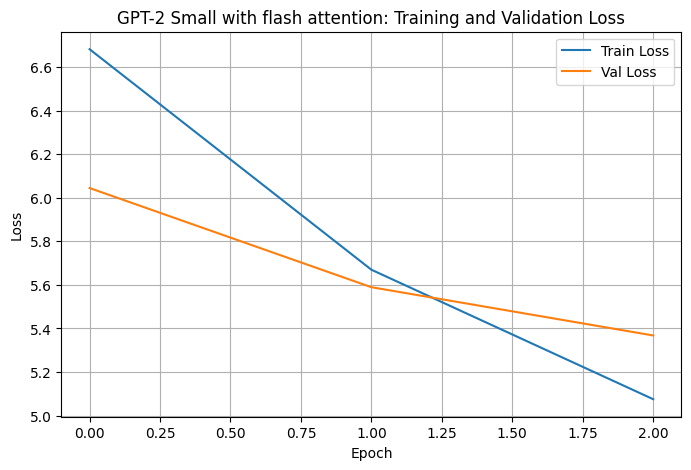

Final Val Loss: 5.3679
Perplexity: 214.42


In [52]:
num_epochs = 3
batch_size = 8
grad_accum_steps = 1

train_losses, val_losses = train(
    small_sparse_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    grad_accum_steps=grad_accum_steps
)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GPT-2 Small with flash attention: Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Perplexity: {math.exp(val_losses[-1]):.2f}")

In [53]:
prompt = "Once upon a time"
print("Greedy decoding:\n", generate_text(small_sparse_model, tokenizer, prompt, strategy="greedy"))
print("\n Top-k sampling (k=50):\n", generate_text(small_sparse_model, tokenizer, prompt, strategy="top-k", top_k=50))
print("\n Nucleus sampling (p=0.9):\n", generate_text(small_sparse_model, tokenizer, prompt, strategy="nucleus", top_p=0.9))

Greedy decoding:
 once upon a time , he was a member of the man who had previously worked on the family . he was the first to be a man who was the first , and was the first to be a man who was the first time to be a man who had a man

 Top-k sampling (k=50):
 once upon a time he came from his first and the rest of his next two seasons , an old man against the next morning " who met with jack , who had previously portrayed . = = = = club football = = = lawton was the fourth world champion at the first

 Nucleus sampling (p=0.9):
 once upon a time , he receives a mycorrhizal ie ly out and allowed him to complete writing , while others get " . he opened the same time about young people and dun ists , but contributed to a saving part in front of a dozen parrot and held by wheeler ' s
